In [57]:
import numpy as np
import cPickle as pickle
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
plt.rc('font', size=50)
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [6]:
pulsar_dicts_m2, _ = pickle.load(open("/.lustre/aoc/students/sstetzle/long_simulations/dicts_M2_SINI/pars_M2_SINI_pulsar_chain_dict.pkl", "rb"))
pulsar_dicts_stig, _ = pickle.load(open("/.lustre/aoc/students/sstetzle/long_simulations/dicts/pars_H3_STIG_pulsar_chain_dict.pkl", "rb"))

def get_chains(PSR, burn=0.25, thin=10):    
    try:
        with open("thinned_chains/pars_H3_H4/{}/chain_burn_{}_thin_{}.txt".format(PSR, burn, thin), "r") as infile:
            data = np.loadtxt(infile)
            key_h3_h4 = 'H3 H4'
            cosi_h3_h4 = data[:, 2]
    except:
        key_h3_h4 = 'H3 H4 (missing)'
        cosi_h3_h4 = []

    try:
        with open("thinned_chains/pars_M2_SINI/{}/chain_burn_{}_thin_{}.txt".format(PSR, burn, thin), "r") as infile:
            data = np.loadtxt(infile)
            key_m2_sini = 'M2 SINI'
            cosi_m2_sini = data[:, 2]
    except:
        if PSR in pulsar_dicts_m2.keys():
            _, _, m2_par_dict = pulsar_dicts_m2[PSR]
            key_m2_sini = 'M2 SINI (old)'
            cosi_m2_sini = m2_par_dict['COSI']
        else:
            key_m2_sini = 'M2 SINI (missing)'
            cosi_m2_sini = []
            
    try:
        with open("thinned_chains/pars_H3_STIG/{}/chain_burn_{}_thin_{}.txt".format(PSR, burn, thin), "r") as infile:
            data = np.loadtxt(infile)
            key_h3_stig = 'H3 STIG'
            cosi_h3_stig = data[:, 2]
    except:
        if PSR in pulsar_dicts_stig.keys():
            _, _, stig_par_dict = pulsar_dicts_stig[PSR]
            key_h3_stig = 'H3 STIG (old)'
            cosi_h3_stig = stig_par_dict['COSI']
        else:
            key_h3_stig = 'H3 STIG (missing)'
            cosi_h3_stig = []
    
    return {key_h3_h4:cosi_h3_h4, key_m2_sini:cosi_m2_sini, key_h3_stig:cosi_h3_stig}

In [75]:
def smooth_plot(par_chain, plot_title, nbins=100, sigma=1, pdfout=None, pngout=None, show_unif=False):
    vals, binedges = np.histogram(par_chain, bins=nbins, density=True, range=(0, 1))
    bins = binedges[:-1] + (binedges[1] - binedges[0]) / 2
    vals = filters.gaussian_filter(vals, sigma=sigma)
    f = interp1d(bins, vals, kind='cubic')

    pdf = f(bins)
    pdf = np.divide(pdf, np.sum(pdf))

    cdf = [np.sum(pdf[:i]) for i in range(len(pdf))]

    fig = plt.figure("pdf", figsize=(6, 4), dpi=100)

    a = plt.plot(bins, f(bins), 'b--', lw=3, zorder=2, label="Smoothed PDF")
    if show_unif:
        plt.plot(np.linspace(0, 1, 1000), np.ones(1000)*sum(f(bins))/nbins, '--', color='orange', lw=3, zorder=1)
    
    fig.axes[0].get_yaxis().set_visible(False)
    plt.xlabel("COSI")
    plt.title(plot_title)
    if pdfout is not None:
        pdfout.savefig()
        plt.close()
    if pngout is not None:
        plt.savefig(pngout)
        plt.close()

In [7]:
all_pulsars = np.genfromtxt("all_pulsars.txt", dtype=str)
good_pulsars = np.genfromtxt("good_pulsars.txt", dtype=str)

In [8]:
all_chains = [get_chains(pulsar, burn=0.5, thin=10) for pulsar in all_pulsars]
good_chains = [get_chains(pulsar, burn=0.5, thin=10) for pulsar in good_pulsars]

In [10]:
all_chains_m2 = [c[c.keys()[1]] for c in all_chains]
all_chains_stig = [c[c.keys()[2]] for c in all_chains]

In [11]:
good_chains_m2 = [c[c.keys()[1]] for c in good_chains]
good_chains_stig = [c[c.keys()[2]] for c in good_chains]

In [22]:
all_chains_m2 = [c for c in all_chains_m2 if len(c) > 0]
all_chains_stig = [c for c in all_chains_stig if len(c) > 0]

good_chains_m2 = [c for c in good_chains_m2 if len(c) > 0]
good_chains_stig = [c for c in good_chains_stig if len(c) > 0]

all_min_length_m2 = min([len(c) for c in all_chains_m2])
all_min_length_stig = min([len(c) for c in all_chains_stig])

all_adjusted_chains_m2 = [c[0:all_min_length_m2] for c in all_chains_m2]
all_adjusted_chains_stig = [c[0:all_min_length_stig] for c in all_chains_stig]

good_min_length_m2 = min([len(c) for c in good_chains_m2])
good_min_length_stig = min([len(c) for c in good_chains_stig])

good_adjusted_chains_m2 = [c[0:good_min_length_m2] for c in good_chains_m2]
good_adjusted_chains_stig = [c[0:good_min_length_stig] for c in good_chains_stig]

all_comp_chain_m2 = np.hstack(all_adjusted_chains_m2)
all_comp_chain_stig = np.hstack(all_adjusted_chains_stig)

good_comp_chain_m2 = np.hstack(good_adjusted_chains_m2)
good_comp_chain_stig = np.hstack(good_adjusted_chains_stig)

In [59]:
smooth_plot(all_comp_chain_m2, "All Pulsars", pngout="all_pulsars_summed.png")

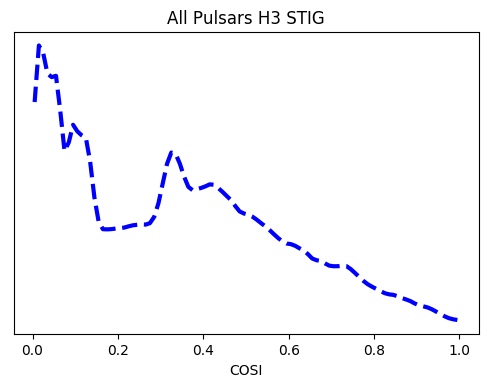

In [31]:
smooth_plot(all_comp_chain_stig, "All Pulsars H3 STIG")

In [80]:
smooth_plot(good_comp_chain_m2, "Combined COSI Probability Distribution", pngout="good_pulsars_summed.png", show_unif=True)

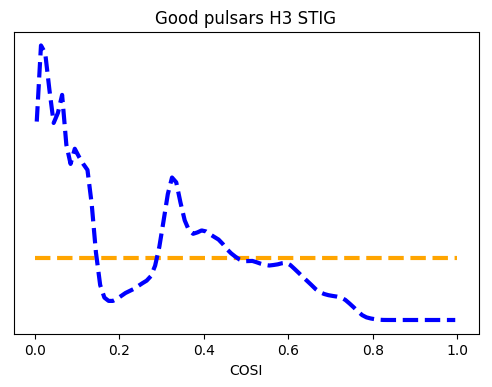

In [77]:
smooth_plot(good_comp_chain_m2, "Good pulsars H3 STIG", show_unif=True)

In [79]:
len(good_chains_m2)

14